1

Parameters of the largest circle
Center: (0.0, 1103.0)
Radius: 40.069384267237695


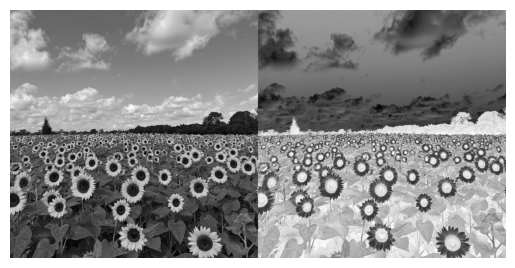

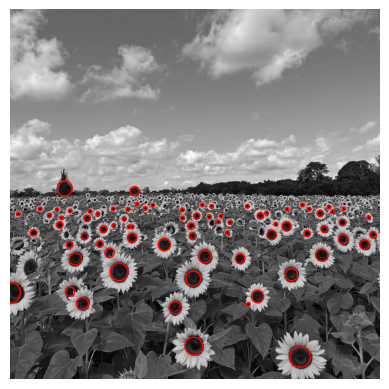

In [142]:
from math import sqrt
from skimage.feature import blob_log
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt


transform = np.arange(255,-1, -1).astype('uint8')
img_orig = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_GRAYSCALE)
img_tr= cv.LUT(img_orig, transform)

res = np.hstack((img_orig,img_tr)) #stacking images side-by-side
plt.axis('off')
plt.imshow(img_orig, cmap='gray')
plt.imshow(res , cmap='gray')
plt.savefig('ans/q1_img1.png')

blobs = blob_log(img_tr, max_sigma=40, min_sigma=5, num_sigma=10, threshold=0.3, overlap = 0.1)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(img_orig, cmap='gray')
max_r =0;
for blob in blobs:
    y, x, area = blob
    if area>=max_r:
        max_r=area
        max_x=x
        max_y=y
    ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', fill=False))
plt.savefig('ans/q1_img2.png')
print('Parameters of the largest circle')
print("Center: ({}, {})".format(max_x, max_y))
print("Radius: {}".format(max_r*np.sqrt(2)))

2

(0.7031613981967063, 0.7110302722711973, 1.4695935981515067)
RANSAC Line: 0.703x + 0.711y = 1.470


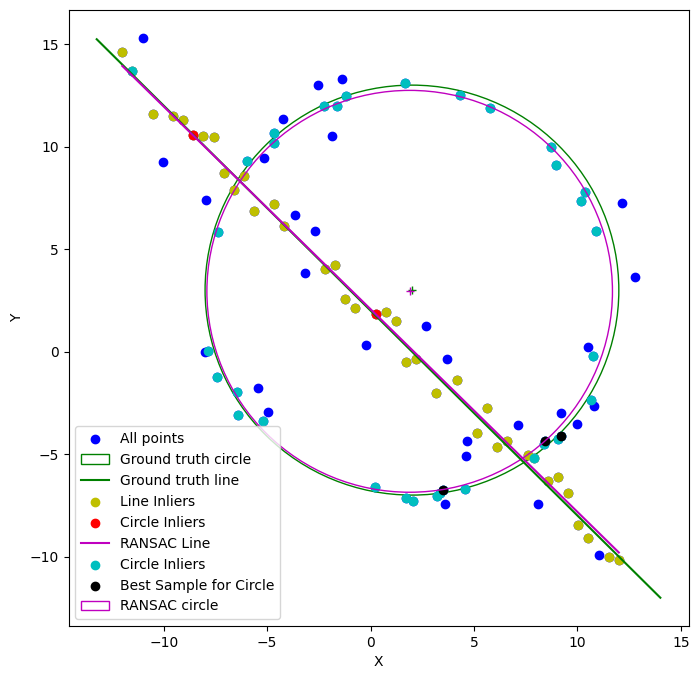

RANSAC Circle: (x - 0.945)^2 + (y - 1.471)^2 = 5.506


In [10]:
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import math
import numpy as np
#import tikzplotlib
#np . random . seed ( 0 )
N = 100
half_n = N// 2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x1 , y1 = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x1. reshape ( half_n , 1 ) , y1 . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # A l l p o in t s
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] ,color='b')
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ],color='b' , label= 'All points')
circle_gt = plt . Circle ( ( x0_gt , y0_gt ) , r , color= 'g', fill =False , label= 'Ground truth circle')
ax . add_patch ( circle_gt )
ax . plot ( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g')
x_min , x_max = ax . get_xlim ( )
x_ = np . array ( [ x_min , x_max ] )
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'g', label= 'Ground truth line')
plt . legend ( )

############# LINE #############

inliercount=35
all_x =np.concatenate((x1,x))
all_y =np.concatenate((y1,y))


def fit_line(x, y):
    A = np.vstack((x, np.ones(len(x)))).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    # Normalize the coefficients a and b
    a = -m / np.sqrt(1 + m**2)
    b = 1 / np.sqrt(1 + m**2)
    c= c / np.sqrt(1 + m**2)
    return a, b, c

def calculate_distance(a, b, c, x, y):
    return np.abs(a * x + b * y - c) / np.sqrt(a**2 + b**2)

def ransac_fit_line(x, y, num_iterations, inlier_threshold):
    best_model = None
    best_inliers = []
    best_error = np.inf

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(x), 2, replace=False)
        sample_x = x[sample_indices]
        sample_y = y[sample_indices]

        a, b, c = fit_line(sample_x, sample_y)

        distances = calculate_distance(a, b, c, x, y)
        inliers = np.where(distances < inlier_threshold)[0]

        error = np.sum(distances[inliers])

        if len(inliers) >= inliercount:
            if error < best_error:
                best_model = (a, b, c)
                best_inliers = inliers
                best_error = error
                best_sample_indices=sample_indices

    return best_model, best_inliers,best_sample_indices


# Set RANSAC parameters
num_iterations = 150
inlier_threshold = 0.7

# Run RANSAC to find the best-fit line
best_fit, inliers, line_sample_indices = ransac_fit_line(all_x, all_y, num_iterations, inlier_threshold)
print(best_fit)
# Extract the best-fit line parameters
best_a, best_b, best_c = best_fit

lineSampleX=all_x[np.isin(np.arange(len(all_x)), line_sample_indices )]
lineSampleY=all_y[np.isin(np.arange(len(all_x)), line_sample_indices )]

line_inliersX = all_x[np.isin(np.arange(len(all_x)), inliers)]
line_inliersY = all_y[np.isin(np.arange(len(all_y)), inliers)]
plt.scatter(line_inliersX, line_inliersY, color='y', label='Line Inliers')
plt.scatter(lineSampleX,lineSampleY,color='r', label='Circle Inliers')
plt.plot(x, (best_c - best_a * x) / best_b, color='m', label='RANSAC Line')


print("RANSAC Line: %.3fx + %.3fy = %.3f" % (best_a, best_b, best_c))


############# CIRCLE #############
def fit_circle(x,y):
    x1, x2, x3 =x[0], x[1], x[2]
    y1, y2, y3 =y[0], y[1], y[2]
    s1 = x1**2 + y1**2
    s2 = x2**2 + y2**2
    s3 = x3**2 + y3**2
    M11 = x1*y2 + x2*y3 + x3*y1 - (x2*y1 + x3*y2 + x1*y3)
    M12 = s1*y2 + s2*y3 + s3*y1 - (s2*y1 + s3*y2 + s1*y3)
    M13 = s1*x2 + s2*x3 + s3*x1 - (s2*x1 + s3*x2 + s1*x3)
    x0 =  0.5*M12/M11
    y0 = -0.5*M13/M11
    r0 = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return (x0, y0, r0)

def calculate_radial_error(a, b, c, x, y):
    return np.abs(c-(np.sqrt(((x-a)**2)+((y-b)**2))))

def ransac_fit_circle(x, y, num_iterations, inlier_threshold, min_inliers):
    best_sample_indices=[]
    best_model = None
    best_inliers = []
    best_error = np.inf

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(x), 3, replace=False)
        sample_x = x[sample_indices]
        sample_y = y[sample_indices]

        a, b, c = fit_circle(sample_x, sample_y)

        distances = calculate_radial_error(a, b, c, x, y)
        inliers = np.where(distances < inlier_threshold)[0]

        if len(inliers) >= min_inliers:
            error = np.sum(distances[inliers])
            if error < best_error:
                best_model = (a, b, c)
                best_inliers = inliers
                best_error = error
                best_sample_indices=sample_indices

    return best_model, best_inliers, best_sample_indices

# Calculate the remnant data (points not on the line)
remnant_x = all_x[~np.isin(np.arange(len(all_x)), inliers)]
remnant_y = all_y[~np.isin(np.arange(len(all_y)), inliers)]
# Set RANSAC parameters for fitting the circle
circle_num_iterations = 150
circle_inlier_threshold = 0.5
circle_min_inliers = 35 # Adjust this based on your dataset and error tolerance

# Run RANSAC to find the best-fit circle for the remnant data
best_circle_fit, circle_inliers, sample_indices_circle = ransac_fit_circle(remnant_x, remnant_y, circle_num_iterations, circle_inlier_threshold, circle_min_inliers)
# Extract the best-fit circle parameters
best_a, best_b, best_c = best_circle_fit
# # Plot the circle fit
sampleCircleX = all_x[np.isin(np.arange(len(all_x)), sample_indices_circle)]
sampleCircleY = all_y[np.isin(np.arange(len(all_x)), sample_indices_circle)]

circleInliersX=all_x[np.isin(np.arange(len(all_x)), circle_inliers)]
circleInliersY=all_y[np.isin(np.arange(len(all_x)), circle_inliers)]


plt.scatter(circleInliersX,circleInliersY,color='c', label='Circle Inliers')
plt.scatter(sampleCircleX ,sampleCircleY ,color='k', label='Best Sample for Circle')
cir = plt . Circle ( (best_a,best_b),best_c,color='m', fill =False , label= 'RANSAC circle')
ax . add_patch ( cir )
ax . plot ( ( best_a ) , ( best_b) , '+' , color= 'm')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.savefig('ans/q2_img.png')
plt.show()
print("RANSAC Circle: (x - %.3f)^2 + (y - %.3f)^2 = %.3f" % (best_a / 2, best_b / 2, (best_c + best_a**2 + best_b**2) / 4))



3

In [152]:
import cv2
import numpy as np

# base image
base_image = cv2.imread('wadham.jpg')
cv2.namedWindow('Select Points')
cv2.imshow('Select Points', base_image)

points_base = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # When the left mouse button is clicked, add the point
        points_base.append([x, y])
        # cv2.circle(base_image, (x, y), 5, (0, 0, 255), -1)
        # cv2.imshow('Select Points', base_image)

# Set the mouse callback function for the window
cv2.setMouseCallback('Select Points', click_event)

# Wait for the user to select four points
while len(points_base) < 4:
    cv2.waitKey(1)

# Close the window
cv2.destroyWindow('Select Points')

# Convert the selected points to a NumPy array
points_base = np.array(points_base, dtype=np.float32)

print("Selected base points:")
print(points_base)

overlay_image = cv2.imread('flag.jpg')
h,w,_ =overlay_image.shape
print(h)
print(w)
points_overlay = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]], dtype=np.float32)

#Get the perspective transform matrix
transform_mat = cv2.getPerspectiveTransform(points_overlay, points_base)

# Warp the overlay image to the base image's perspective
height, width, _ = base_image.shape
warped_image = cv2.warpPerspective(overlay_image, transform_mat, (width, height))

# Blend 
composite_image = cv2.addWeighted(warped_image, 0.4, base_image, 0.7, 0)

cv2.imshow('Superimposed Image', composite_image)
cv2.imwrite('Superimposed Image1.jpg', composite_image)
cv2.waitKey(0)
cv2.destroyAllWindows()



Selected base points:
[[ 58.  80.]
 [ 44. 209.]
 [172. 128.]
 [168. 222.]]
600
1200


In [153]:
##ex 2
import cv2
import numpy as np

# base image
base_image = cv2.imread('stadium.jpg')
cv2.namedWindow('Select Points')
cv2.imshow('Select Points', base_image)

points_base = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # When the left mouse button is clicked, add the point
        points_base.append([x, y])
        # cv2.circle(base_image, (x, y), 5, (0, 0, 255), -1)
        # cv2.imshow('Select Points', base_image)

# Set the mouse callback function for the window
cv2.setMouseCallback('Select Points', click_event)

# Wait for the user to select four points
while len(points_base) < 4:
    cv2.waitKey(1)

# Close the window
cv2.destroyWindow('Select Points')

# Convert the selected points to a NumPy array
points_base = np.array(points_base, dtype=np.float32)

overlay_image = cv2.imread('ad.jpg')
h,w,_ =overlay_image.shape

points_overlay = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]], dtype=np.float32)

#Get the perspective transform matrix
transform_mat = cv2.getPerspectiveTransform(points_overlay, points_base)

# Warp the overlay image to the base image's perspective
height, width, _ = base_image.shape
warped_image = cv2.warpPerspective(overlay_image, transform_mat, (width, height))

# Blend 
composite_image = cv2.addWeighted(warped_image, 0.3, base_image, 0.8, 0)

cv2.imshow('Superimposed Image', composite_image)
cv2.imwrite('Superimposed Image2.jpg', composite_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

4

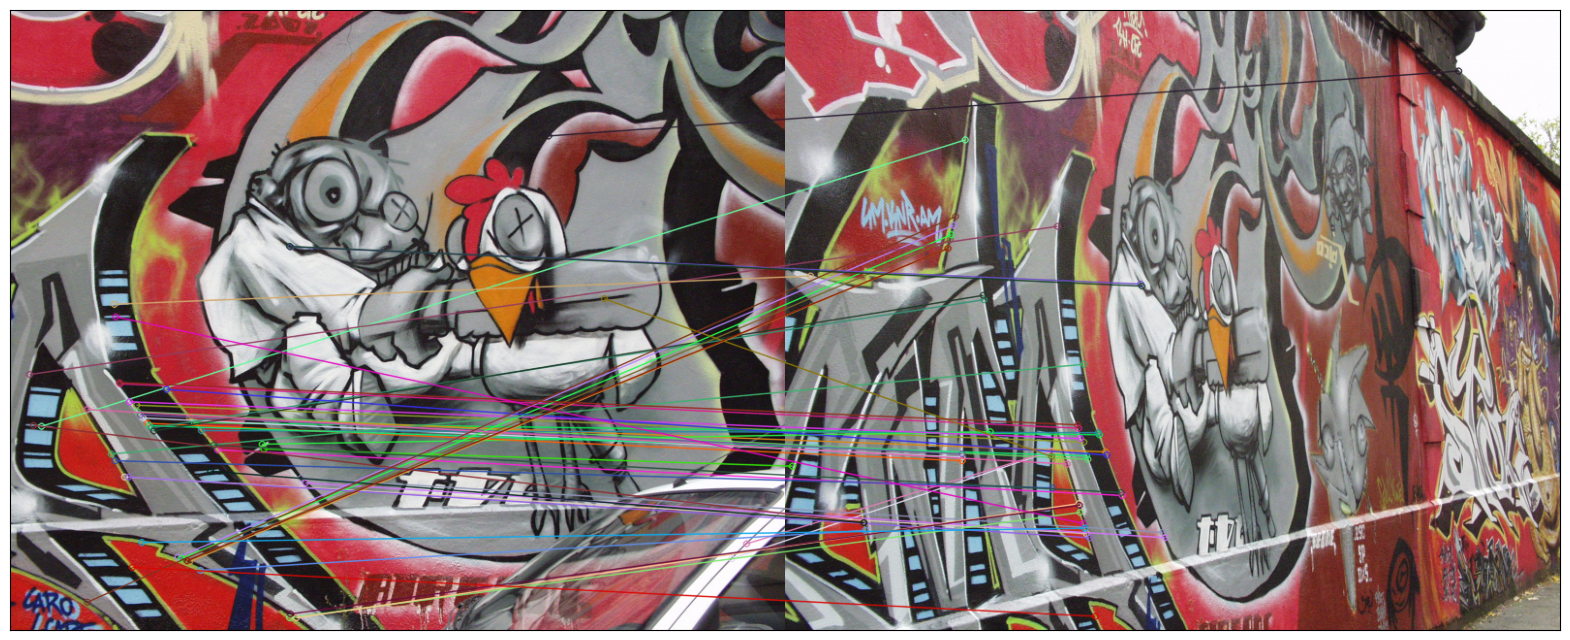

In [154]:
##a
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')


img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.1, edgeThreshold = 25, sigma = 1)
bf = cv.BFMatcher(cv.NORM_L2SQR, crossCheck=True)

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.match(des1, des5)
matches = sorted(matches, key=lambda x:x.distance)

out_img = cv.drawMatches(img1, key1, img5, key5, matches[:50], img5, flags=2)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('ans/q4_a.png')

plt.show()

In [174]:
##b

sift = cv.SIFT_create()

kp1, desc1 = sift.detectAndCompute(img1, None)
kp2, desc2 = sift.detectAndCompute(img5, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)
good, pts1, pts2 = [], [], []

for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

good, pts1, pts2 = np.array(good), np.array(pts1), np.array(pts2)
matched_img = cv.drawMatchesKnn(img1, kp1, img5, kp2, good[:50], None, flags=2)

def compute_homography(pts1, pts2):
    mean1, mean2 = np.mean(pts1, axis=0), np.mean(pts2, axis=0)
    s1, s2 = len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts1-mean1)**2, axis=1))), len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts2-mean2)**2, axis=1)))
    tx1, ty1, tx2, ty2 = -s1*mean1[0], -s1*mean1[1], -s2*mean2[0], -s2*mean2[1]
    T1, T2 = np.array(((s1, 0, tx1), (0, s1, ty1), (0, 0, 1))), np.array(((s2, 0, tx2), (0, s2, ty2), (0, 0, 1)))
    A = []

    for i in range(len(pts1)):
        X11, X21 = T1 @ np.concatenate((pts1[i], [1])).reshape(3, 1), T2 @ np.concatenate((pts2[i], [1])).reshape(3, 1)
        A.append((-X11[0][0], -X11[1][0], -1, 0, 0, 0, X21[0][0]*X11[0][0], X21[0][0]*X11[1][0], X21[0][0]))
        A.append((0, 0, 0, -X11[0][0], -X11[1][0], -1, X21[1][0]*X11[0][0], X21[1][0]*X11[1][0], X21[1][0]))
    
    A = np.array(A)
    U, S, V = np.linalg.svd(A, full_matrices=True)
    h = np.reshape(V[-1], (3, 3))
    H = linalg.inv(T2) @ h @ T1
    H = (1 / H.item(8)) * H
    return H
        
def dist(P1, P2, H):
    p1 = np.array([P1[0], P1[1], 1])
    p2 = np.array([P2[0], P2[1], 1])

    p2_estimate = np.dot(H, p1.T)
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    return np.linalg.norm(p2.T - p2_estimate)

def RANSAC_h(points1, points2):
    inlier_count, selected_inliers = 0, None
    points = np.hstack((points1, points2))
    num_iterations = int(np.log(1 - 0.99)/np.log(1 - (1 - 0.5)**4))
    
    for _ in range(num_iterations):
        np.random.shuffle(points)
        pts1, pts1_rem, pts2, pts2_rem = points[:4, :2],  points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = compute_homography(pts1, pts2)
        inliers = [(pts1_rem[i], pts2_rem[i]) for i in range(len(pts1_rem)) if dist(pts1_rem[i], pts2_rem[i], H) < 20]
        if len(inliers) > inlier_count:
            inlier_count = len(inliers)
            selected_inliers = np.array(inliers)
    
    H = compute_homography(selected_inliers[:, 0], selected_inliers[:, 1])
    return H

H = RANSAC_h(pts1, pts2)
print(H)

[[ 7.11405939e-01 -5.96705727e-01  4.61091489e+02]
 [ 8.24039751e-01 -2.22453159e-02  8.80141548e+01]
 [ 1.31996899e-03 -1.14071413e-03  1.00000000e+00]]


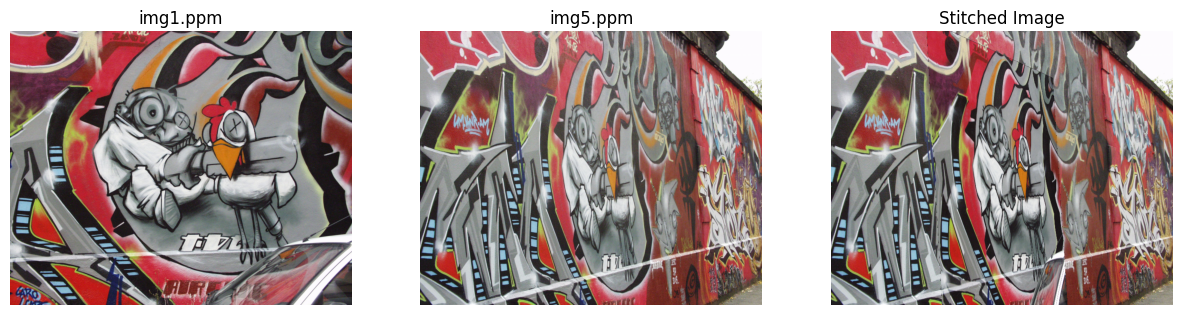

In [156]:
file = open("H1to5p", "r")
H = []

for _ in range(3):
   H.append(tuple(map(float, file.readline().strip().split())))

H = np.array(H)
img_p = cv.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))
ret, threshold = cv.threshold(img_p, 10, 1, cv.THRESH_BINARY_INV)
img2_thresholded = np.multiply(threshold, img5)
img_blended = cv.addWeighted(img2_thresholded, 1, img_p, 1, 0)

fig, ax = plt.subplots(1, 3, figsize=(15, 12))
ax[0].imshow(img1)
ax[0].set_title("img1.ppm")
ax[0].axis("off")
ax[1].imshow(img5)
ax[1].set_title("img5.ppm")
ax[1].axis("off")
ax[2].imshow(img_blended)
ax[2].set_title("Stitched Image")
ax[2].axis("off")
plt.savefig('ans/q4_c.png')

plt.show()